# Interactive chart using ipywidgets


Covid data from Johns Hopkins data repository. Using [ipywidgets](https://ipywidgets.readthedocs.io/en/stable) for interactive use.
* Display the rolling average for those countries with the highest number of deaths 
    * Change the number of days to set the rolling average (slider from 1 to 10)
    * Change the number of recent days to view (dropdown selection)



In [1]:
# import libraries
%matplotlib widget
import ipywidgets as widgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data for Deaths from COVID-19.

Load data into Pandas dataframes directly from Johns Hopkins data repository.



In [2]:
# Number of Death Cases - Global: time series data for deaths
deaths_path = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deaths_df = pd.read_csv(deaths_path)

print(f"Shape of deaths = {deaths_df.shape}")

Shape of deaths = (274, 460)


In [3]:
def clean_covid_data(df):
    # 1. Drop unwanted columns
    df.drop(["Province/State", "Lat", "Long"], axis=1, inplace=True)

    # 2. Group by Country
    df = df.groupby("Country/Region").sum()

    # 3. Convert column headings to datetime
    df.columns = pd.to_datetime(df.columns)

    # 4. Remove the column name
    df.rename_axis(None, axis=0, inplace=True)

    return df

In [4]:
clean_deaths_df = clean_covid_data(deaths_df)

In [5]:
daily_deaths_df = clean_deaths_df.diff(axis=1)

---

In [6]:
class average_deaths(widgets.VBox):
    df = None
    output = widgets.Output()
    rolling_days = 7
    recent_days = 100

    def __init__(self, df):
        super().__init__()
        self.df = df

        # create the chart
        self.create_chart()

        # create and layout the widget controls
        controls = self.create_control_panel()

        # add the widgets to the view
        self.children = [controls, self.output]

    def create_chart(self):
        """create the chart in the widget output control"""
        with self.output:
            self.fig, self.ax = plt.subplots(
                figsize=(9, 5), facecolor=plt.cm.Blues(0.2)
            )
            self.fig.suptitle(
                "Deaths from COVID-19", fontsize="xx-large", fontweight="bold"
            )
            self.plot_axis()
            self.fig.autofmt_xdate()
            plt.tight_layout()
            self.fig.canvas.toolbar_position = "bottom"

    def create_control_panel(self):
        """create the slider and dropdown controls"""
        rolling_slider = widgets.IntSlider(
            value=self.rolling_days,
            min=1,
            max=10,
            step=1,
        )
        recent_dropdown = widgets.Dropdown(
            options=[50, 100, 200, 300, 1000],
            value=self.recent_days,
            description="",
            disabled=False,
        )
        controls = widgets.HBox(
            [
                widgets.VBox(
                    [
                        widgets.Label("Rolling Average Days: "),
                        widgets.Label("Recent Number of Days: "),
                    ]
                ),
                widgets.VBox([rolling_slider, recent_dropdown]),
            ]
        )
        controls.layout = self.control_box_layout()

        # hook up the widgets to observe changes
        rolling_slider.observe(self.update_rollout, "value")
        recent_dropdown.observe(self.update_recent, "value")
        return controls

    def control_box_layout(self):
        """create layout for control panel"""
        return widgets.Layout(
            border="solid 1px Navy",
            margin="0px 10px 10px 0px",
            padding="5px 5px 5px 5px",
        )

    def update_rollout(self, change):
        """update the chart with changes in rolling frequency"""
        self.rolling_days = change.new
        self.plot_axis()
        self.fig.autofmt_xdate()

    def update_recent(self, change):
        """update the chart with changes in recent number of days"""
        self.recent_days = change.new
        self.plot_axis()
        self.fig.autofmt_xdate()

    def plot_axis(self):
        """clear any previous chart and plot the lines for the top countries"""
        self.ax.clear()
        self.ax.set_title(
            f"{self.rolling_days}-day rolling average, for the last {self.recent_days} days"
        )
        self.ax.set_facecolor(plt.cm.Blues(0.2))
        rolling_df = self.df.rolling(self.rolling_days, axis=1).mean()
        top_countries = list(
            rolling_df.iloc[:, -1].sort_values(ascending=False).head(10).index
        )
        for i, country in enumerate(top_countries[:5]):
            self.ax.plot(
                self.df.columns[-self.recent_days :],
                rolling_df.loc[country].tail(self.recent_days),
                label=country,
                color=plt.cm.tab10(i),
            )
        self.ax.legend(
            bbox_to_anchor=(1, 0.8), loc="upper left", facecolor=plt.cm.Blues(0.1)
        )
        self.ax.set_xlabel("Date", fontsize="large", fontweight="bold")
        self.ax.set_ylabel("Number of Deaths", fontsize="large", fontweight="bold")
        self.ax.spines["right"].set_visible(False)
        self.ax.spines["top"].set_visible(False)


average_deaths(daily_deaths_df)

average_deaths(children=(HBox(children=(VBox(children=(Label(value='Rolling Average Days: '), Label(value='Rec…

---

## Create non-interactive chart for preview display in Jupyter notebook

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

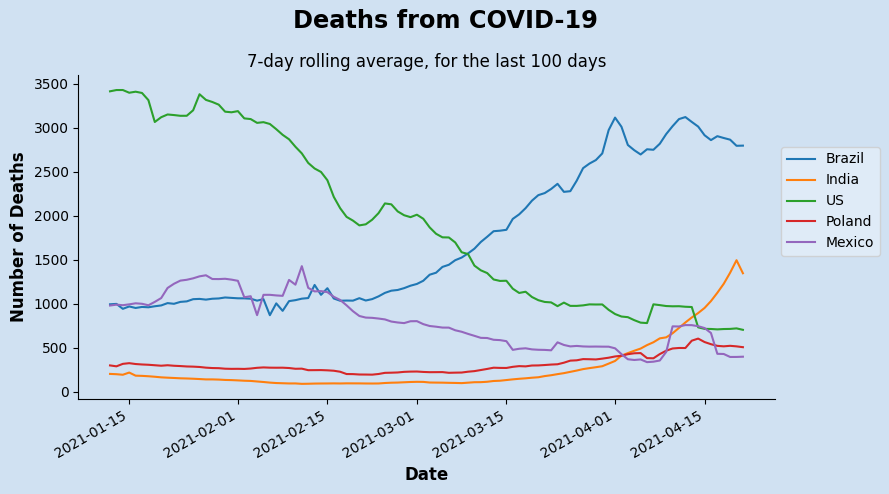

In [7]:
def create_non_interactive_chart(df, rolling_days, recent_days):
    fig, ax = plt.subplots(
        figsize=(9, 5), facecolor=plt.cm.Blues(0.2)
    )
    fig.suptitle(
        "Deaths from COVID-19", fontsize="xx-large", fontweight="bold"
    )
    ax.set_title(
        f"{rolling_days}-day rolling average, for the last {recent_days} days"
    )
    ax.set_facecolor(plt.cm.Blues(0.2))
    rolling_df = df.rolling(rolling_days, axis=1).mean()
    top_countries = list(rolling_df.iloc[:, -1].sort_values(ascending=False).head(10).index)
    for i, country in enumerate(top_countries[:5]):
        ax.plot(
            df.columns[-recent_days :],
            rolling_df.loc[country].tail(recent_days),
            label=country,
            color=plt.cm.tab10(i),
        )
    ax.legend(
        bbox_to_anchor=(1, 0.8), loc="upper left", facecolor=plt.cm.Blues(0.1)
    )
    ax.set_xlabel("Date", fontsize="large", fontweight="bold")
    ax.set_ylabel("Number of Deaths", fontsize="large", fontweight="bold")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    fig.autofmt_xdate()
    plt.tight_layout()
    fig.canvas.toolbar_position = "bottom"
    return fig

create_non_interactive_chart(daily_deaths_df, 7, 100)